In [2]:
import numpy as np
import pandas as pd
import pathlib
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
# Define the path to the dataset in Kaggle
data_dir = pathlib.Path('/kaggle/input/ads-lab-skin-disease-dataset/Skin Disease Classification Dataset/New folder')
data_dir

PosixPath('/kaggle/input/ads-lab-skin-disease-dataset/Skin Disease Classification Dataset/New folder')

In [4]:
# Load image file paths from each class folder
acne = list(data_dir.glob('acne/*/*.jpg')) 
vitiligo = list(data_dir.glob('Vitiligo/*/*.jpg'))
hyperpigmentation = list(data_dir.glob('hyperpigmentation/*/*.jpeg'))
nail_psoriasis = list(data_dir.glob('Nail_psoriasis/*/*.jpeg'))
sjs_ten = list(data_dir.glob('SJS-TEN/*/*.jpeg'))

In [92]:
print(acne[10])

/kaggle/input/ads-lab-skin-disease-dataset/Skin Disease Classification Dataset/New folder/acne/acne/saturation-200150__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpg


In [6]:
# Contains the image paths for each category
df_images = {
    'Acne': acne,
    'Vitiligo': vitiligo,
    'Hyperpigmentation': hyperpigmentation,
    'Nail Psoriasis': nail_psoriasis,
    'SJS-TEN': sjs_ten
}
# Contains the numerical labels for each category
df_labels = {
    'Acne': 0,
    'Vitiligo': 1,
    'Hyperpigmentation': 2,
    'Nail Psoriasis': 3,
    'SJS-TEN': 4
}

In [7]:
import cv2
img = cv2.imread(str(df_images['Acne'][0]))

In [8]:
img.shape

(122, 294, 3)

In [9]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [10]:
X, y = [], []

for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(label)

In [11]:
X = np.array(X)
y = np.array(y)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,random_state=42)

In [38]:
X_train.shape

(6664, 224, 224, 3)

In [36]:
from tensorflow.keras import layers
import tensorflow as tf
import keras
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras import Sequential, Model
from tensorflow.keras.metrics import Precision, Recall

In [17]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [19]:
print(X_train.shape)  # Should print (num_samples, 224, 224, 3) for RGB images
print(X_train.dtype)  # Should print float32 or float64

(6664, 224, 224, 3)
uint8


In [20]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Converts ['Acne', 'Eczema', ...] → [0, 1, ...]
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot
y_train_categorical = to_categorical(y_train_encoded, num_classes=5)
y_test_categorical = to_categorical(y_test_encoded, num_classes=5)

# Normalize input images
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [18]:

from keras.callbacks import ModelCheckpoint, EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True
)

**VGG16**

In [79]:
from tensorflow.keras.applications.vgg16 import VGG16
res = VGG16(weights ='imagenet', include_top = False, input_shape = (224, 224, 3))

# Freeze the base model
res.trainable = False

x = res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Optional dropout (you can uncomment if needed)
# x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(5, activation='softmax')(x)  # 5-class softmax classifier

# Build the model
model = Model(inputs=res.input, outputs=x)

# Compile with extra metrics
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_13          │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_137              │ (None, 512)                 │           2,0

 Total params: 15,115,077 (57.66 MB)

 Trainable params: 397,829 (1.52 MB)

 Non-trainable params: 14,717,248 (56.14 MB)

In [80]:
hist = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=50,
    batch_size=32,
    callbacks=[custom_early_stopping]
)

Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 72s 324ms/step - accuracy: 0.6838 - loss: 0.9641 - precision: 0.7396 - recall: 0.6325 - val_accuracy: 0.6215 - val_loss: 0.9075 - val_precision: 0.7580 - val_recall: 0.4881
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 60s 287ms/step - accuracy: 0.8571 - loss: 0.4016 - precision: 0.8861 - recall: 0.8324 - val_accuracy: 0.8519 - val_loss: 0.4315 - val_precision: 0.8844 - val_recall: 0.8116
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 59s 285ms/step - accuracy: 0.8953 - loss: 0.2852 - precision: 0.9156 - recall: 0.8792 - val_accuracy: 0.8351 - val_loss: 0.4510 - val_precision: 0.8478 - val_recall: 0.8228
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 60s 287ms/step - accuracy: 0.9151 - loss: 0.2413 - precision: 0.9274 - recall: 0.9023 - val_accuracy: 0.8796 - val_loss: 0.3464 - val_precision: 0.8905 - val_recall: 0.8659
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 60s 288ms/step - accuracy: 0.9300 - loss: 0.1980 - precision: 0.9398 - recall: 0.9211 - val_accuracy: 0.8988

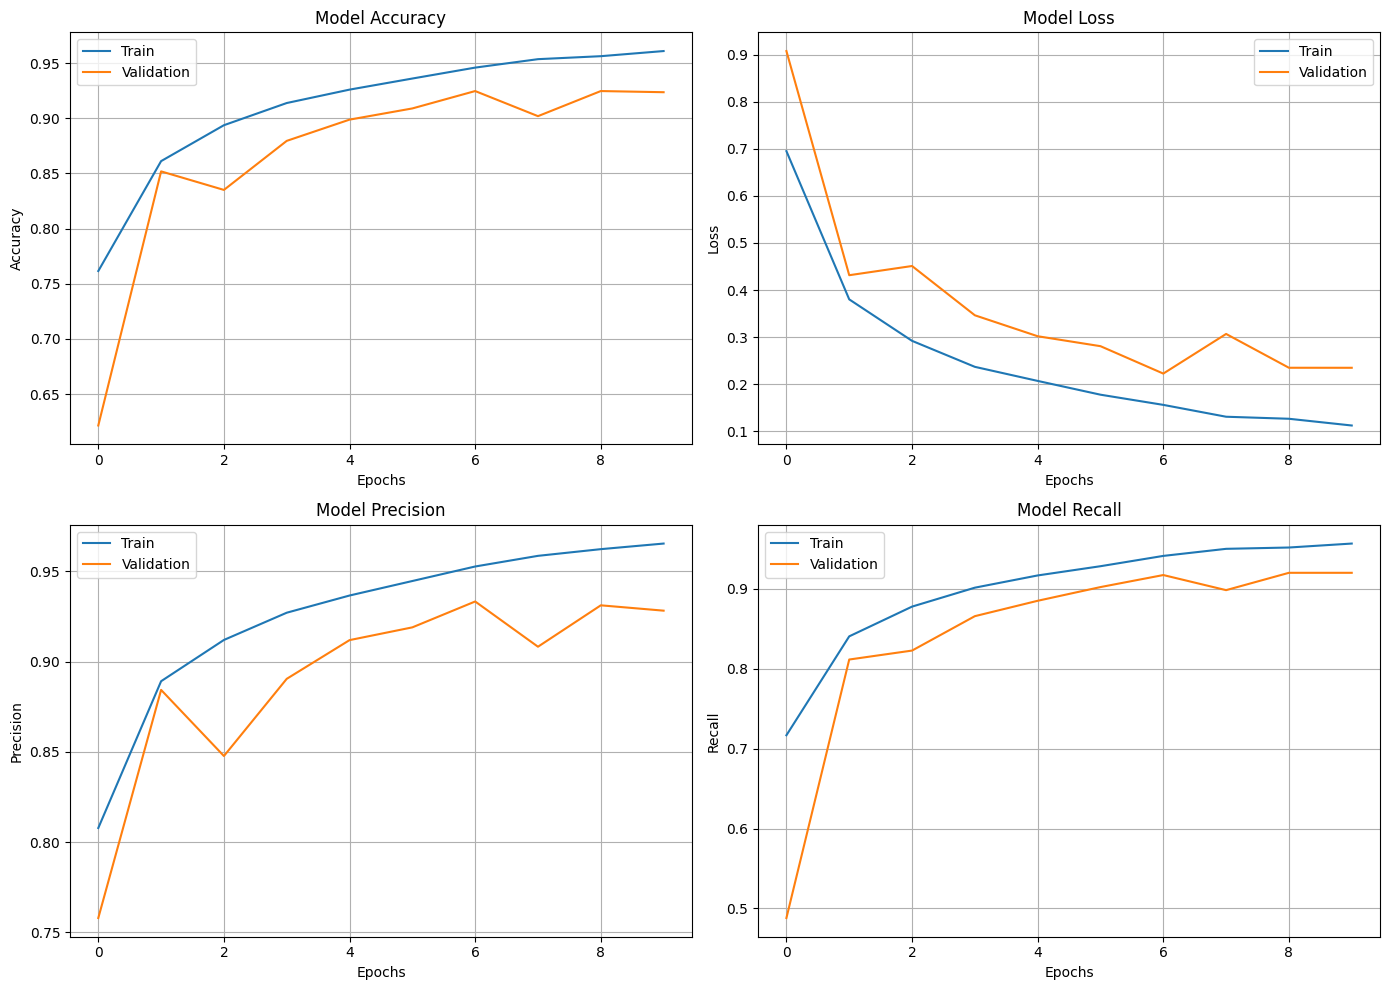

In [81]:
import matplotlib.pyplot as plt

# Set up 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].plot(hist.history['accuracy'])
axs[0, 0].plot(hist.history['val_accuracy'])
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(['Train', 'Validation'])
axs[0, 0].grid(True)

# Loss
axs[0, 1].plot(hist.history['loss'])
axs[0, 1].plot(hist.history['val_loss'])
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(['Train', 'Validation'])
axs[0, 1].grid(True)

# Precision
axs[1, 0].plot(hist.history['precision'])
axs[1, 0].plot(hist.history['val_precision'])
axs[1, 0].set_title('Model Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(['Train', 'Validation'])
axs[1, 0].grid(True)

# Recall
axs[1, 1].plot(hist.history['recall'])
axs[1, 1].plot(hist.history['val_recall'])
axs[1, 1].set_title('Model Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend(['Train', 'Validation'])
axs[1, 1].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()

**VGG19**

In [82]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import RMSprop

# Load the VGG19 base model
res = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
res.trainable = False

# Add custom top layers
x = res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Optional Dropout
# x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(5, activation='softmax')(x)  # 5-class classifier

# Define the model
model = Model(inputs=res.input, outputs=x)

# Compile the model with extra metrics
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# Show model summary
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,424,773 (77.91 MB)

 Trainable params: 397,829 (1.52 MB)

 Non-trainable params: 20,026,944 (76.40 MB)

In [84]:
hist = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=50,
    batch_size=32,
    callbacks=[custom_early_stopping]
)

Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 66s 317ms/step - accuracy: 0.8424 - loss: 0.4373 - precision: 0.8689 - recall: 0.8141 - val_accuracy: 0.8256 - val_loss: 0.4670 - val_precision: 0.8676 - val_recall: 0.7868
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 68s 326ms/step - accuracy: 0.8802 - loss: 0.3226 - precision: 0.9026 - recall: 0.8611 - val_accuracy: 0.8501 - val_loss: 0.3914 - val_precision: 0.8745 - val_recall: 0.8295
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 71s 342ms/step - accuracy: 0.9096 - loss: 0.2563 - precision: 0.9226 - recall: 0.8915 - val_accuracy: 0.8298 - val_loss: 0.4657 - val_precision: 0.8461 - val_recall: 0.8144
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 76s 363ms/step - accuracy: 0.9219 - loss: 0.2247 - precision: 0.9336 - recall: 0.9136 - val_accuracy: 0.8904 - val_loss: 0.3291 - val_precision: 0.9026 - val_recall: 0.8732
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 76s 363ms/step - accuracy: 0.9288 - loss: 0.1943 - precision: 0.9386 - recall: 0.9211 - val_accuracy: 0.8785

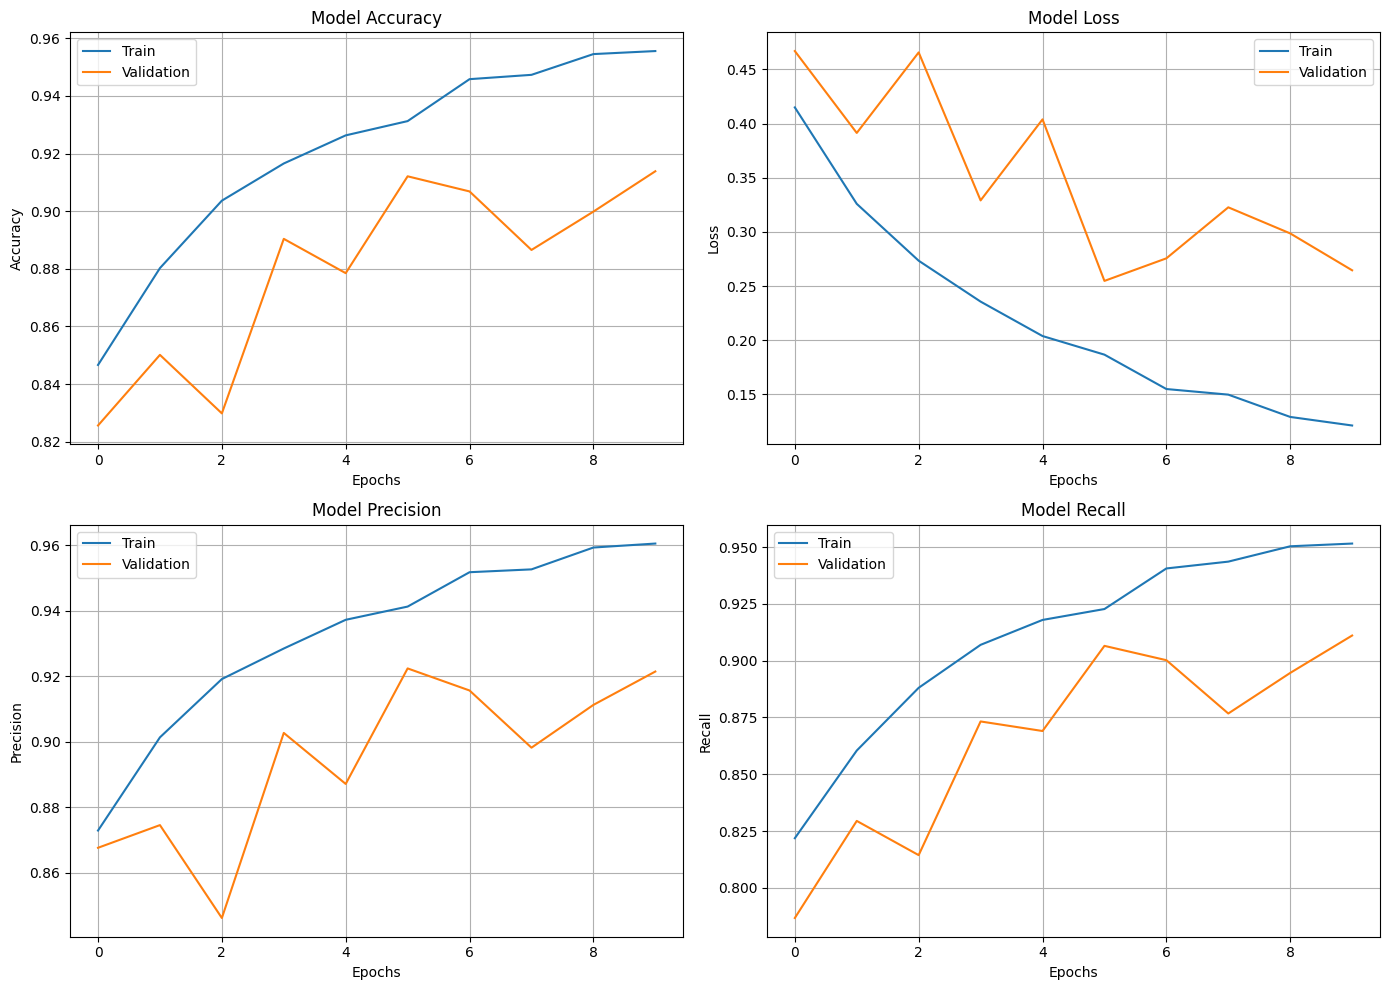

In [85]:
import matplotlib.pyplot as plt

# Set up 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].plot(hist.history['accuracy'])
axs[0, 0].plot(hist.history['val_accuracy'])
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(['Train', 'Validation'])
axs[0, 0].grid(True)

# Loss
axs[0, 1].plot(hist.history['loss'])
axs[0, 1].plot(hist.history['val_loss'])
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(['Train', 'Validation'])
axs[0, 1].grid(True)

# Precision
axs[1, 0].plot(hist.history['precision'])
axs[1, 0].plot(hist.history['val_precision'])
axs[1, 0].set_title('Model Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(['Train', 'Validation'])
axs[1, 0].grid(True)

# Recall
axs[1, 1].plot(hist.history['recall'])
axs[1, 1].plot(hist.history['val_recall'])
axs[1, 1].set_title('Model Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend(['Train', 'Validation'])
axs[1, 1].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()

**ResNet50**

In [86]:
from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.optimizers import RMSprop
# Load ResNet50 base model
res = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
res.trainable = False

# Add custom layers on top
x = res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Optional dropout to help with generalization
# x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(5, activation='softmax')(x)  # 5-class classifier

# Build the model
model = Model(inputs=res.input, outputs=x)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# Show model summary
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,780,677 (94.53 MB)

 Trainable params: 1,187,333 (4.53 MB)

 Non-trainable params: 23,593,344 (90.00 MB)

In [87]:
hist = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=50,
    batch_size=32,
    callbacks=[custom_early_stopping]
)

Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 52s 179ms/step - accuracy: 0.4589 - loss: 1.4885 - precision: 0.5556 - recall: 0.3084 - val_accuracy: 0.2798 - val_loss: 1.7143 - val_precision: 0.2826 - val_recall: 0.2630
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy: 0.5825 - loss: 1.0725 - precision: 0.6938 - recall: 0.4450 - val_accuracy: 0.5032 - val_loss: 1.4224 - val_precision: 0.5789 - val_recall: 0.4251
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.6387 - loss: 0.9309 - precision: 0.7272 - recall: 0.5291 - val_accuracy: 0.5606 - val_loss: 1.1598 - val_precision: 0.6892 - val_recall: 0.4674
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - accuracy: 0.6759 - loss: 0.8337 - precision: 0.7578 - recall: 0.5859 - val_accuracy: 0.6250 - val_loss: 0.9882 - val_precision: 0.7091 - val_recall: 0.5368
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - accuracy: 0.7136 - loss: 0.7581 - precision: 0.7739 - recall: 0.6274 - val_accuracy: 0.6548

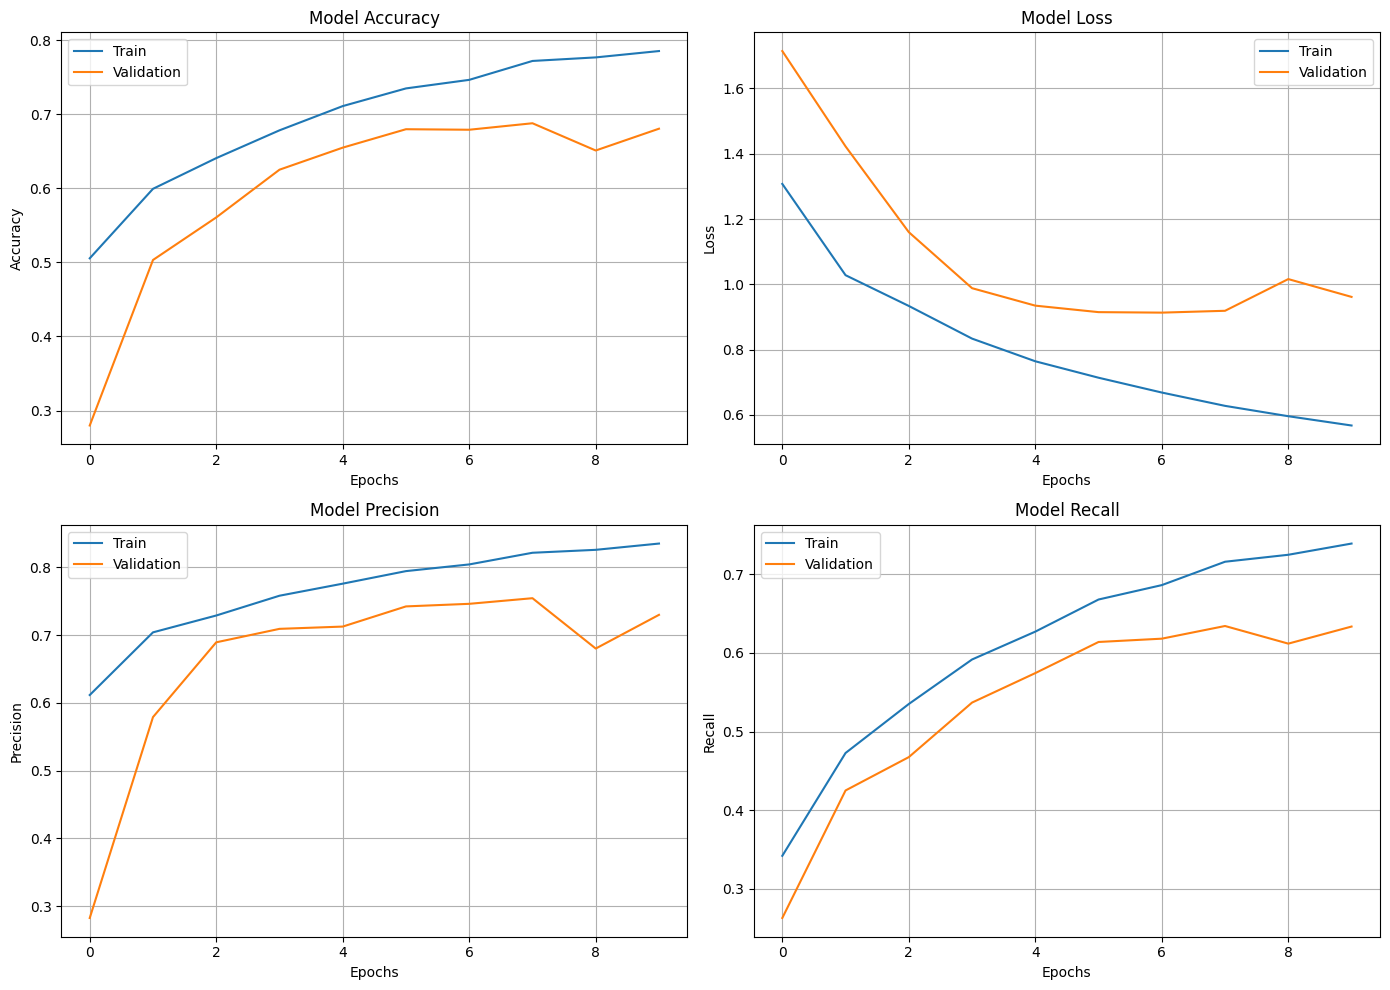

In [88]:
import matplotlib.pyplot as plt

# Set up 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].plot(hist.history['accuracy'])
axs[0, 0].plot(hist.history['val_accuracy'])
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(['Train', 'Validation'])
axs[0, 0].grid(True)

# Loss
axs[0, 1].plot(hist.history['loss'])
axs[0, 1].plot(hist.history['val_loss'])
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(['Train', 'Validation'])
axs[0, 1].grid(True)

# Precision
axs[1, 0].plot(hist.history['precision'])
axs[1, 0].plot(hist.history['val_precision'])
axs[1, 0].set_title('Model Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(['Train', 'Validation'])
axs[1, 0].grid(True)

# Recall
axs[1, 1].plot(hist.history['recall'])
axs[1, 1].plot(hist.history['val_recall'])
axs[1, 1].set_title('Model Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend(['Train', 'Validation'])
axs[1, 1].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()

**ResNet101**

In [89]:
from tensorflow.keras.applications import ResNet101

# Load ResNet101 base model
res = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
res.trainable = False

# Add custom layers on top
x = res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Optional dropout to help with generalization
# x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(5, activation='softmax')(x)  # 5-class classifier

# Build the model
model = Model(inputs=res.input, outputs=x)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# Show model summary
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 43,851,141 (167.28 MB)

 Trainable params: 1,187,333 (4.53 MB)

 Non-trainable params: 42,663,808 (162.75 MB)

In [90]:
hist = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=50,
    batch_size=32,
    callbacks=[custom_early_stopping]
)

Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 94s 331ms/step - accuracy: 0.4306 - loss: 1.5922 - precision: 0.5034 - recall: 0.2713 - val_accuracy: 0.3796 - val_loss: 1.4324 - val_precision: 0.6016 - val_recall: 0.0539
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 51s 242ms/step - accuracy: 0.5784 - loss: 1.0792 - precision: 0.6887 - recall: 0.4344 - val_accuracy: 0.5336 - val_loss: 1.1826 - val_precision: 0.7229 - val_recall: 0.2356
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 49s 235ms/step - accuracy: 0.6277 - loss: 0.9498 - precision: 0.7299 - recall: 0.5151 - val_accuracy: 0.5270 - val_loss: 1.1914 - val_precision: 0.6114 - val_recall: 0.4314
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 50s 238ms/step - accuracy: 0.6412 - loss: 0.9034 - precision: 0.7405 - recall: 0.5411 - val_accuracy: 0.5826 - val_loss: 1.0926 - val_precision: 0.6541 - val_recall: 0.5098
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 49s 237ms/step - accuracy: 0.6788 - loss: 0.8199 - precision: 0.7659 - recall: 0.5861 - val_accuracy: 0.5616

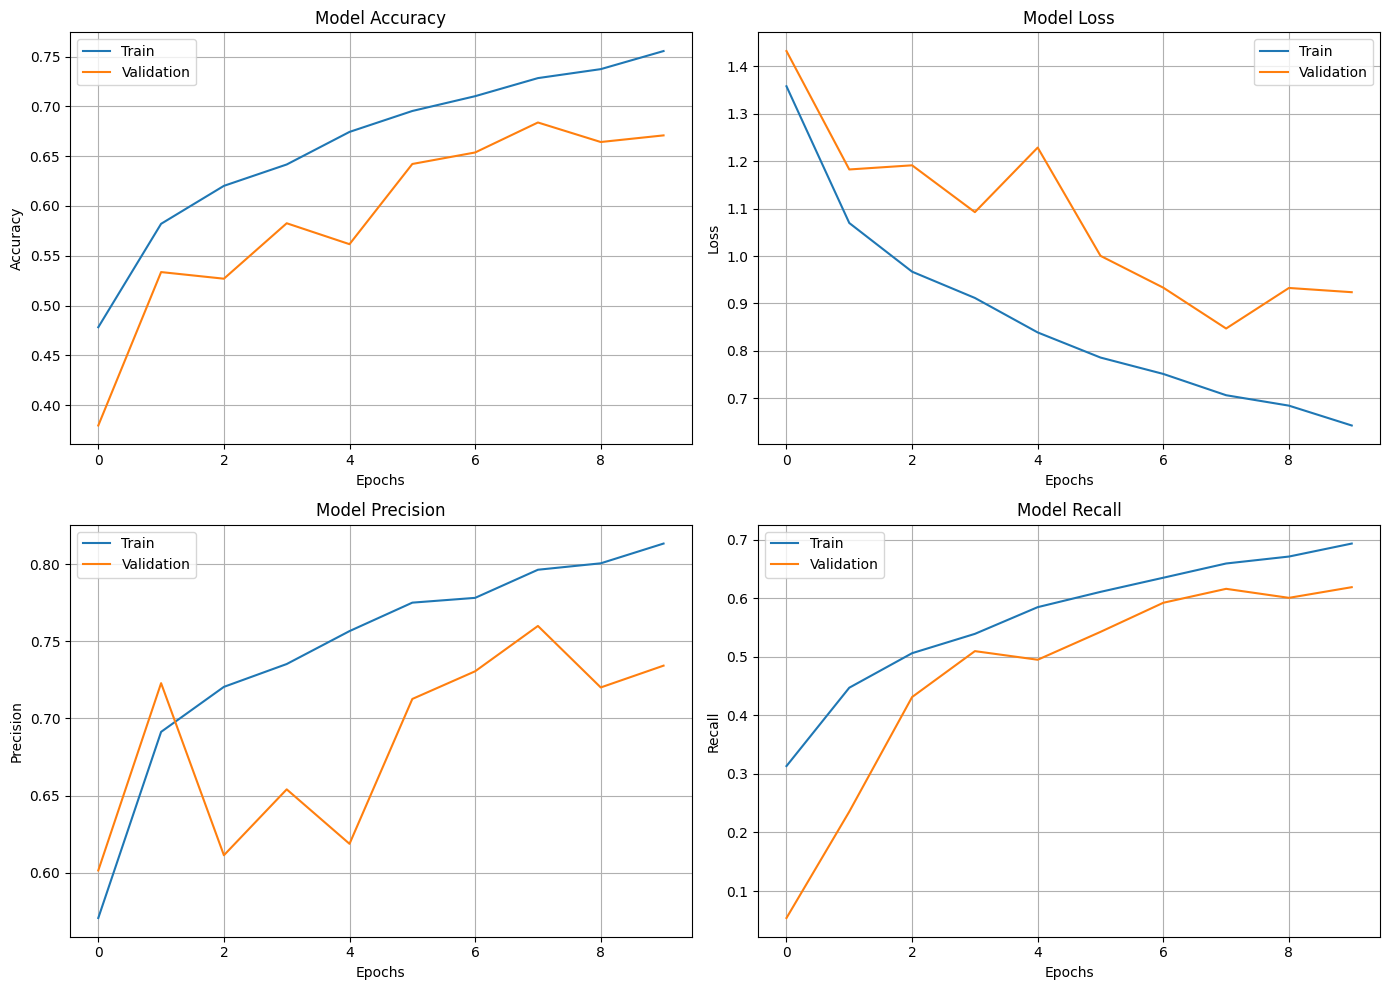

In [91]:
import matplotlib.pyplot as plt

# Set up 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].plot(hist.history['accuracy'])
axs[0, 0].plot(hist.history['val_accuracy'])
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(['Train', 'Validation'])
axs[0, 0].grid(True)

# Loss
axs[0, 1].plot(hist.history['loss'])
axs[0, 1].plot(hist.history['val_loss'])
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(['Train', 'Validation'])
axs[0, 1].grid(True)

# Precision
axs[1, 0].plot(hist.history['precision'])
axs[1, 0].plot(hist.history['val_precision'])
axs[1, 0].set_title('Model Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(['Train', 'Validation'])
axs[1, 0].grid(True)

# Recall
axs[1, 1].plot(hist.history['recall'])
axs[1, 1].plot(hist.history['val_recall'])
axs[1, 1].set_title('Model Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend(['Train', 'Validation'])
axs[1, 1].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()

**ResNet152**

In [39]:
from tensorflow.keras.applications import ResNet152

res = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
res.trainable = False

# Add custom layers on top
x = res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Optional dropout to help with generalization
# x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(5, activation='softmax')(x)  # 5-class classifier

# Build the model
model = Model(inputs=res.input, outputs=x)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# Show model summary
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 59,563,909 (227.22 MB)

 Trainable params: 1,187,333 (4.53 MB)

 Non-trainable params: 58,376,576 (222.69 MB)

In [41]:
hist = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=20,
    batch_size=32,
    callbacks=[custom_early_stopping]
)

Epoch 1/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 129s 435ms/step - accuracy: 0.4488 - loss: 1.5216 - precision: 0.5278 - recall: 0.2960 - val_accuracy: 0.2675 - val_loss: 1.6826 - val_precision: 0.2741 - val_recall: 0.2630
Epoch 2/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 65s 312ms/step - accuracy: 0.5735 - loss: 1.0663 - precision: 0.6836 - recall: 0.4455 - val_accuracy: 0.4608 - val_loss: 1.3653 - val_precision: 0.5745 - val_recall: 0.3806
Epoch 3/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 68s 326ms/step - accuracy: 0.6421 - loss: 0.9124 - precision: 0.7340 - recall: 0.5369 - val_accuracy: 0.5697 - val_loss: 1.1112 - val_precision: 0.6596 - val_recall: 0.4608
Epoch 4/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 69s 331ms/step - accuracy: 0.6717 - loss: 0.8253 - precision: 0.7596 - recall: 0.5869 - val_accuracy: 0.6268 - val_loss: 1.0257 - val_precision: 0.7192 - val_recall: 0.5228
Epoch 5/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 70s 334ms/step - accuracy: 0.7066 - loss: 0.7695 - precision: 0.7838 - recall: 0.6187 - val_accuracy: 0.611

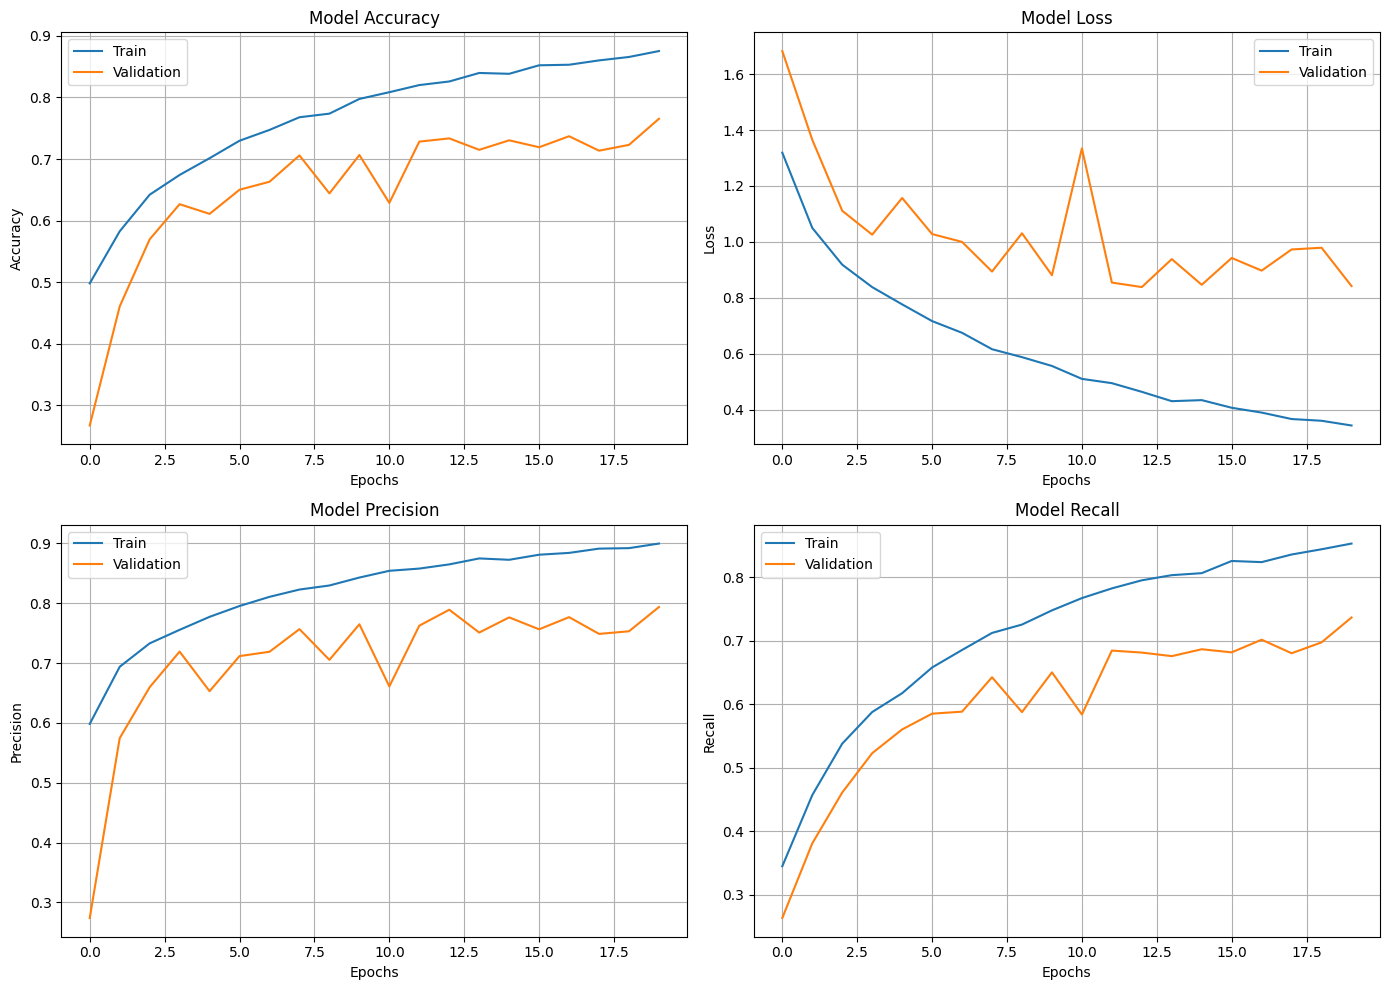

In [54]:
import matplotlib.pyplot as plt

# Set up 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].plot(hist.history['accuracy'])
axs[0, 0].plot(hist.history['val_accuracy'])
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(['Train', 'Validation'])
axs[0, 0].grid(True)

# Loss
axs[0, 1].plot(hist.history['loss'])
axs[0, 1].plot(hist.history['val_loss'])
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(['Train', 'Validation'])
axs[0, 1].grid(True)

# Precision
axs[1, 0].plot(hist.history['precision'])
axs[1, 0].plot(hist.history['val_precision'])
axs[1, 0].set_title('Model Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(['Train', 'Validation'])
axs[1, 0].grid(True)

# Recall
axs[1, 1].plot(hist.history['recall'])
axs[1, 1].plot(hist.history['val_recall'])
axs[1, 1].set_title('Model Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend(['Train', 'Validation'])
axs[1, 1].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()


**Xception**

In [55]:
from tensorflow.keras.applications import Xception

res = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
res.trainable = False

# Add custom layers on top
x = res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Optional dropout to help with generalization
# x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(5, activation='softmax')(x)  # 5-class classifier

# Build the model
model = Model(inputs=res.input, outputs=x)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# Show model summary
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 22,054,445 (84.13 MB)

 Trainable params: 1,187,333 (4.53 MB)

 Non-trainable params: 20,867,112 (79.60 MB)

In [60]:
hist = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=20,
    batch_size=32,
    callbacks=[custom_early_stopping]
)

Epoch 1/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 45s 217ms/step - accuracy: 0.9928 - loss: 0.0202 - precision: 0.9928 - recall: 0.9923 - val_accuracy: 0.9489 - val_loss: 0.2252 - val_precision: 0.9505 - val_recall: 0.9471
Epoch 2/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 43s 204ms/step - accuracy: 0.9934 - loss: 0.0177 - precision: 0.9934 - recall: 0.9931 - val_accuracy: 0.9163 - val_loss: 0.3905 - val_precision: 0.9185 - val_recall: 0.9160
Epoch 3/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 49s 234ms/step - accuracy: 0.9933 - loss: 0.0268 - precision: 0.9941 - recall: 0.9929 - val_accuracy: 0.9394 - val_loss: 0.3142 - val_precision: 0.9407 - val_recall: 0.9387
Epoch 4/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 47s 225ms/step - accuracy: 0.9949 - loss: 0.0145 - precision: 0.9949 - recall: 0.9949 - val_accuracy: 0.9478 - val_loss: 0.2549 - val_precision: 0.9498 - val_recall: 0.9471
Epoch 5/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 48s 231ms/step - accuracy: 0.9959 - loss: 0.0106 - precision: 0.9959 - recall: 0.9958 - val_accuracy: 0.9513

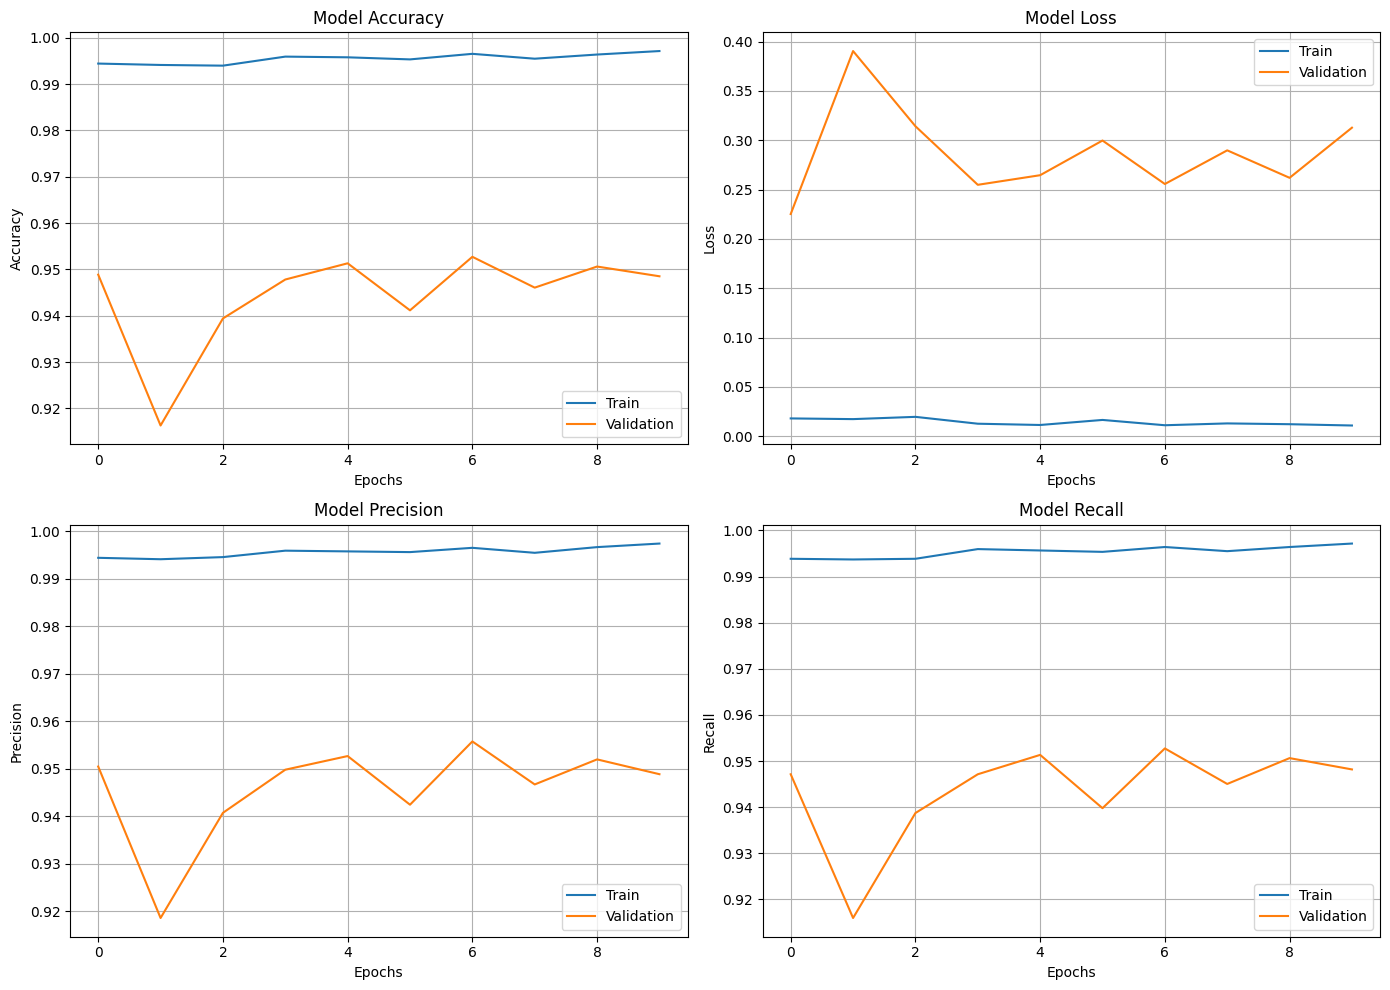

In [61]:
import matplotlib.pyplot as plt

# Set up 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].plot(hist.history['accuracy'])
axs[0, 0].plot(hist.history['val_accuracy'])
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(['Train', 'Validation'])
axs[0, 0].grid(True)

# Loss
axs[0, 1].plot(hist.history['loss'])
axs[0, 1].plot(hist.history['val_loss'])
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(['Train', 'Validation'])
axs[0, 1].grid(True)

# Precision
axs[1, 0].plot(hist.history['precision'])
axs[1, 0].plot(hist.history['val_precision'])
axs[1, 0].set_title('Model Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(['Train', 'Validation'])
axs[1, 0].grid(True)

# Recall
axs[1, 1].plot(hist.history['recall'])
axs[1, 1].plot(hist.history['val_recall'])
axs[1, 1].set_title('Model Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend(['Train', 'Validation'])
axs[1, 1].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()

**DenseNet121**

In [62]:
from tensorflow.keras.applications import DenseNet121

res = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
res.trainable = False

# Add custom layers on top
x = res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Optional dropout to help with generalization
# x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(5, activation='softmax')(x)  # 5-class classifier

# Build the model
model = Model(inputs=res.input, outputs=x)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# Show model summary
model.summary()

# Set up early stopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_8[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,702,085 (29.38 MB)

 Trainable params: 660,997 (2.52 MB)

 Non-trainable params: 7,041,088 (26.86 MB)

In [63]:
hist = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=20,
    batch_size=32,
    callbacks=[custom_early_stopping]
)

Epoch 1/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 86s 257ms/step - accuracy: 0.7831 - loss: 0.6441 - precision: 0.8186 - recall: 0.7453 - val_accuracy: 0.9016 - val_loss: 0.2694 - val_precision: 0.9221 - val_recall: 0.8869
Epoch 2/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.9339 - loss: 0.1912 - precision: 0.9431 - recall: 0.9295 - val_accuracy: 0.9184 - val_loss: 0.2306 - val_precision: 0.9259 - val_recall: 0.9139
Epoch 3/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.9614 - loss: 0.1143 - precision: 0.9635 - recall: 0.9586 - val_accuracy: 0.9275 - val_loss: 0.2607 - val_precision: 0.9300 - val_recall: 0.9216
Epoch 4/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - accuracy: 0.9626 - loss: 0.0977 - precision: 0.9664 - recall: 0.9596 - val_accuracy: 0.9349 - val_loss: 0.2070 - val_precision: 0.9373 - val_recall: 0.9314
Epoch 5/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy: 0.9781 - loss: 0.0639 - precision: 0.9795 - recall: 0.9765 - val_accuracy: 0.9520

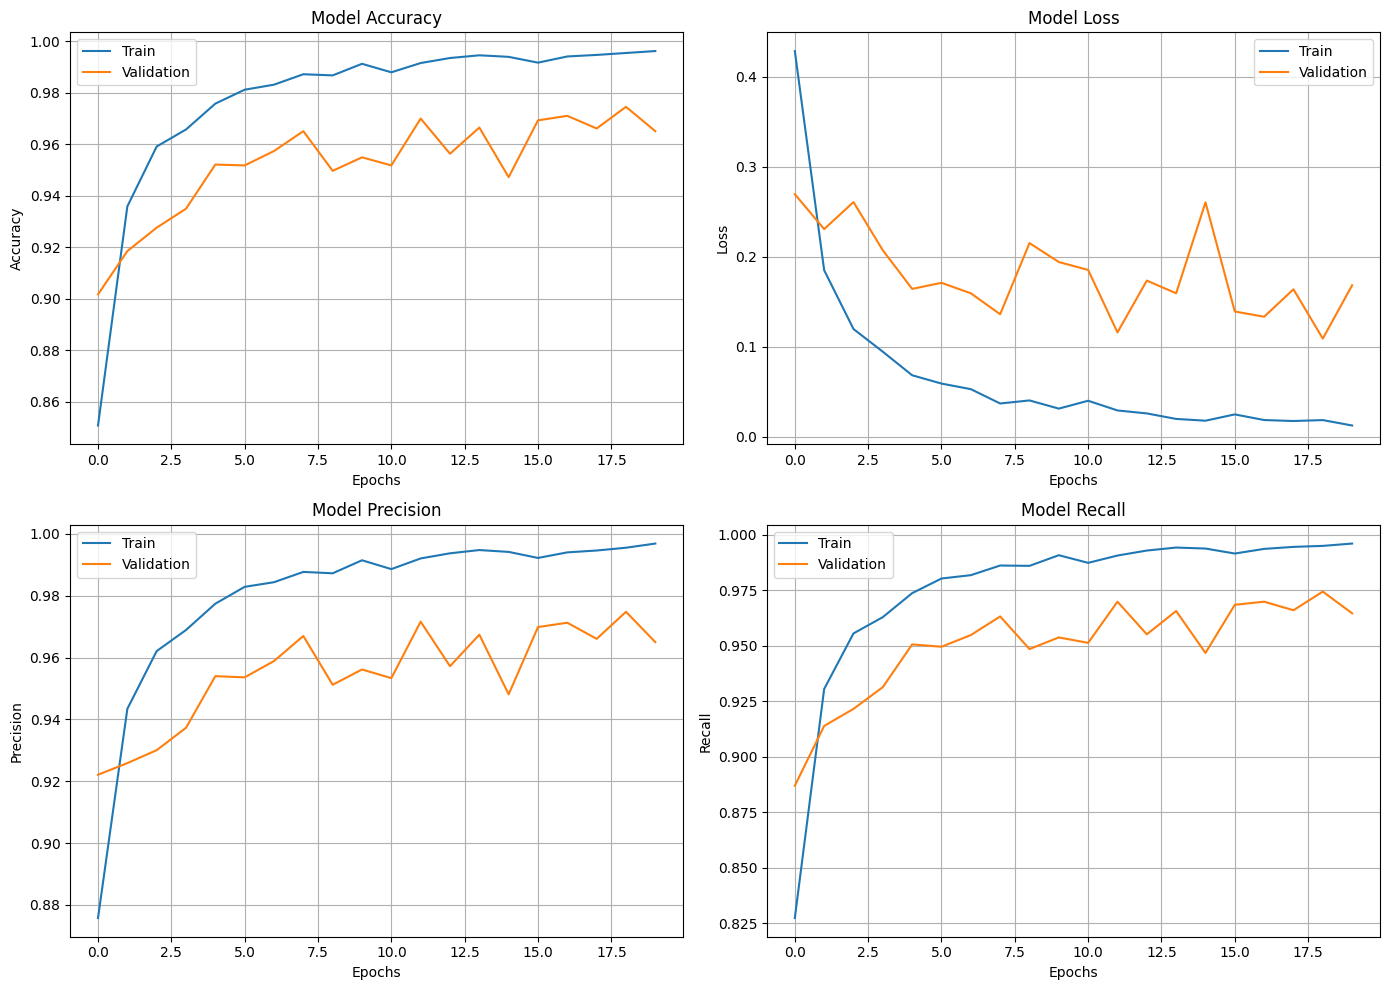

In [64]:
import matplotlib.pyplot as plt

# Set up 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].plot(hist.history['accuracy'])
axs[0, 0].plot(hist.history['val_accuracy'])
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(['Train', 'Validation'])
axs[0, 0].grid(True)

# Loss
axs[0, 1].plot(hist.history['loss'])
axs[0, 1].plot(hist.history['val_loss'])
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(['Train', 'Validation'])
axs[0, 1].grid(True)

# Precision
axs[1, 0].plot(hist.history['precision'])
axs[1, 0].plot(hist.history['val_precision'])
axs[1, 0].set_title('Model Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(['Train', 'Validation'])
axs[1, 0].grid(True)

# Recall
axs[1, 1].plot(hist.history['recall'])
axs[1, 1].plot(hist.history['val_recall'])
axs[1, 1].set_title('Model Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend(['Train', 'Validation'])
axs[1, 1].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()

**DenseNet169**

In [65]:
from tensorflow.keras.applications import DenseNet169


res = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
res.trainable = False

# Add custom layers on top
x = res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Optional dropout to help with generalization
# x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(5, activation='softmax')(x)  # 5-class classifier

# Build the model
model = Model(inputs=res.input, outputs=x)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# Show model summary
model.summary()

# Set up early stopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True
)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_9[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 13,637,701 (52.02 MB)

 Trainable params: 989,957 (3.78 MB)

 Non-trainable params: 12,647,744 (48.25 MB)

In [66]:
hist = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=20,
    batch_size=32,
    callbacks=[custom_early_stopping]
)

Epoch 1/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 116s 359ms/step - accuracy: 0.7824 - loss: 0.6675 - precision: 0.8219 - recall: 0.7586 - val_accuracy: 0.8894 - val_loss: 0.3092 - val_precision: 0.9000 - val_recall: 0.8796
Epoch 2/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 31s 147ms/step - accuracy: 0.9422 - loss: 0.1638 - precision: 0.9481 - recall: 0.9366 - val_accuracy: 0.9317 - val_loss: 0.2003 - val_precision: 0.9374 - val_recall: 0.9279
Epoch 3/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 29s 140ms/step - accuracy: 0.9658 - loss: 0.0956 - precision: 0.9699 - recall: 0.9626 - val_accuracy: 0.9503 - val_loss: 0.1547 - val_precision: 0.9532 - val_recall: 0.9482
Epoch 4/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step - accuracy: 0.9735 - loss: 0.0828 - precision: 0.9756 - recall: 0.9713 - val_accuracy: 0.9524 - val_loss: 0.1568 - val_precision: 0.9563 - val_recall: 0.9492
Epoch 5/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - accuracy: 0.9845 - loss: 0.0499 - precision: 0.9854 - recall: 0.9835 - val_accuracy: 0.946

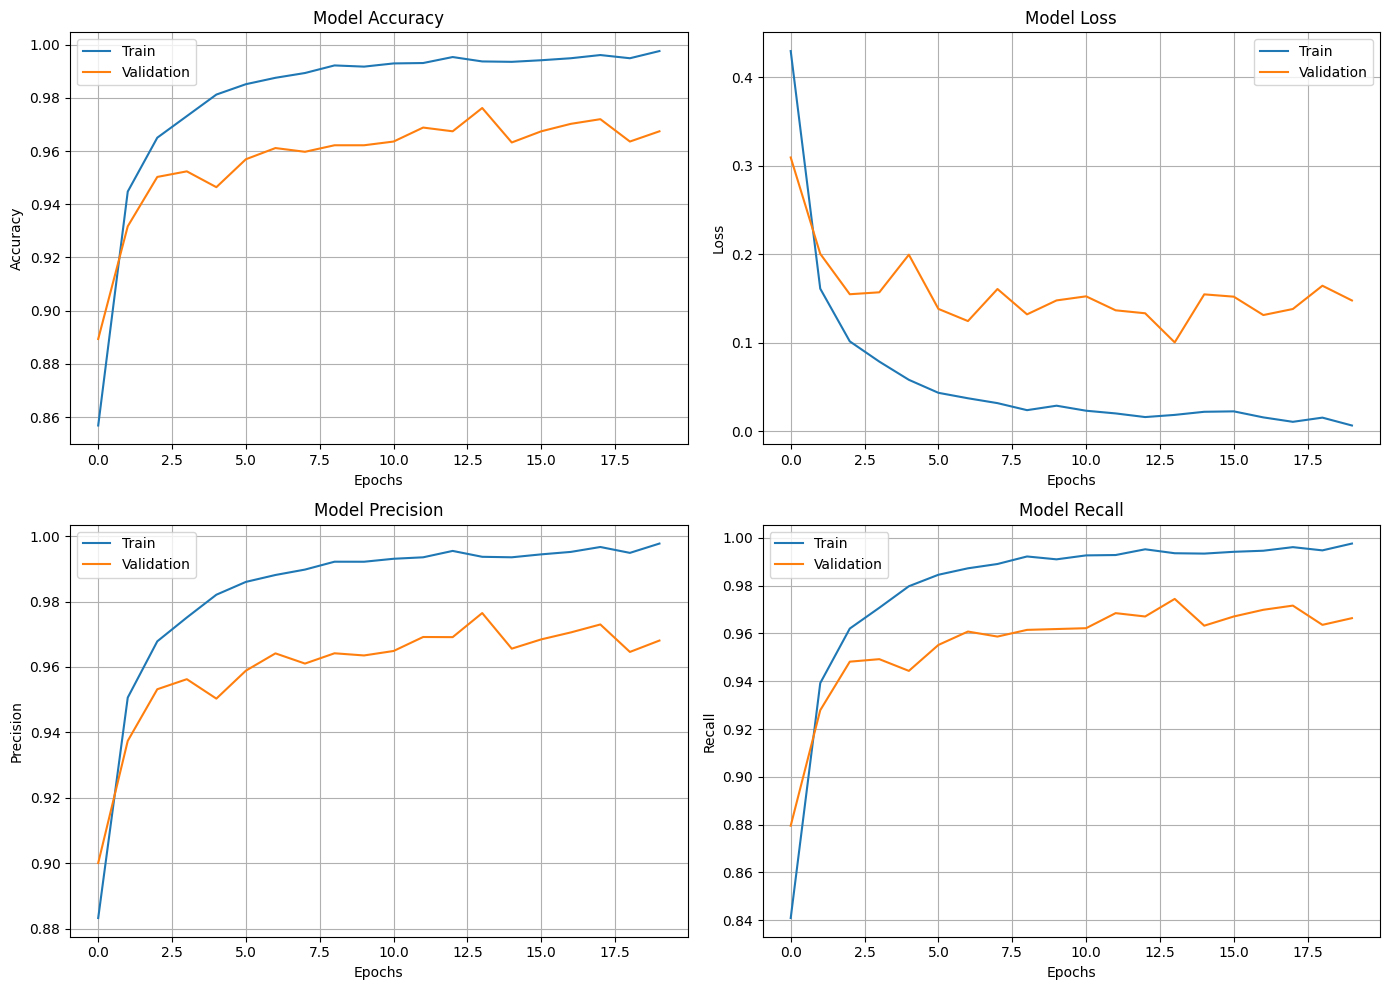

In [67]:
import matplotlib.pyplot as plt

# Set up 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].plot(hist.history['accuracy'])
axs[0, 0].plot(hist.history['val_accuracy'])
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(['Train', 'Validation'])
axs[0, 0].grid(True)

# Loss
axs[0, 1].plot(hist.history['loss'])
axs[0, 1].plot(hist.history['val_loss'])
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(['Train', 'Validation'])
axs[0, 1].grid(True)

# Precision
axs[1, 0].plot(hist.history['precision'])
axs[1, 0].plot(hist.history['val_precision'])
axs[1, 0].set_title('Model Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(['Train', 'Validation'])
axs[1, 0].grid(True)

# Recall
axs[1, 1].plot(hist.history['recall'])
axs[1, 1].plot(hist.history['val_recall'])
axs[1, 1].set_title('Model Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend(['Train', 'Validation'])
axs[1, 1].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()

**DenseNet201**

In [68]:
from tensorflow.keras.applications import DenseNet201

# Load ResNet101 base model
res = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
res.trainable = False

# Add custom layers on top
x = res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Optional dropout to help with generalization
# x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(5, activation='softmax')(x)  # 5-class classifier

# Build the model
model = Model(inputs=res.input, outputs=x)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# Show model summary
model.summary()

# Set up early stopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True
)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 230, 230, 3)    │              0 │ input_layer_10[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 19,448,901 (74.19 MB)

 Trainable params: 1,121,541 (4.28 MB)

 Non-trainable params: 18,327,360 (69.91 MB)

In [69]:
hist = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=20,
    batch_size=32,
    callbacks=[custom_early_stopping]
)

Epoch 1/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 142s 449ms/step - accuracy: 0.7866 - loss: 0.6622 - precision: 0.8169 - recall: 0.7565 - val_accuracy: 0.9055 - val_loss: 0.2677 - val_precision: 0.9134 - val_recall: 0.8978
Epoch 2/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 39s 188ms/step - accuracy: 0.9373 - loss: 0.1713 - precision: 0.9444 - recall: 0.9315 - val_accuracy: 0.9237 - val_loss: 0.2216 - val_precision: 0.9282 - val_recall: 0.9195
Epoch 3/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - accuracy: 0.9664 - loss: 0.1044 - precision: 0.9697 - recall: 0.9635 - val_accuracy: 0.9576 - val_loss: 0.1117 - val_precision: 0.9605 - val_recall: 0.9524
Epoch 4/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 38s 180ms/step - accuracy: 0.9716 - loss: 0.0922 - precision: 0.9741 - recall: 0.9699 - val_accuracy: 0.9436 - val_loss: 0.1909 - val_precision: 0.9462 - val_recall: 0.9422
Epoch 5/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.9817 - loss: 0.0561 - precision: 0.9825 - recall: 0.9810 - val_accuracy: 0.968

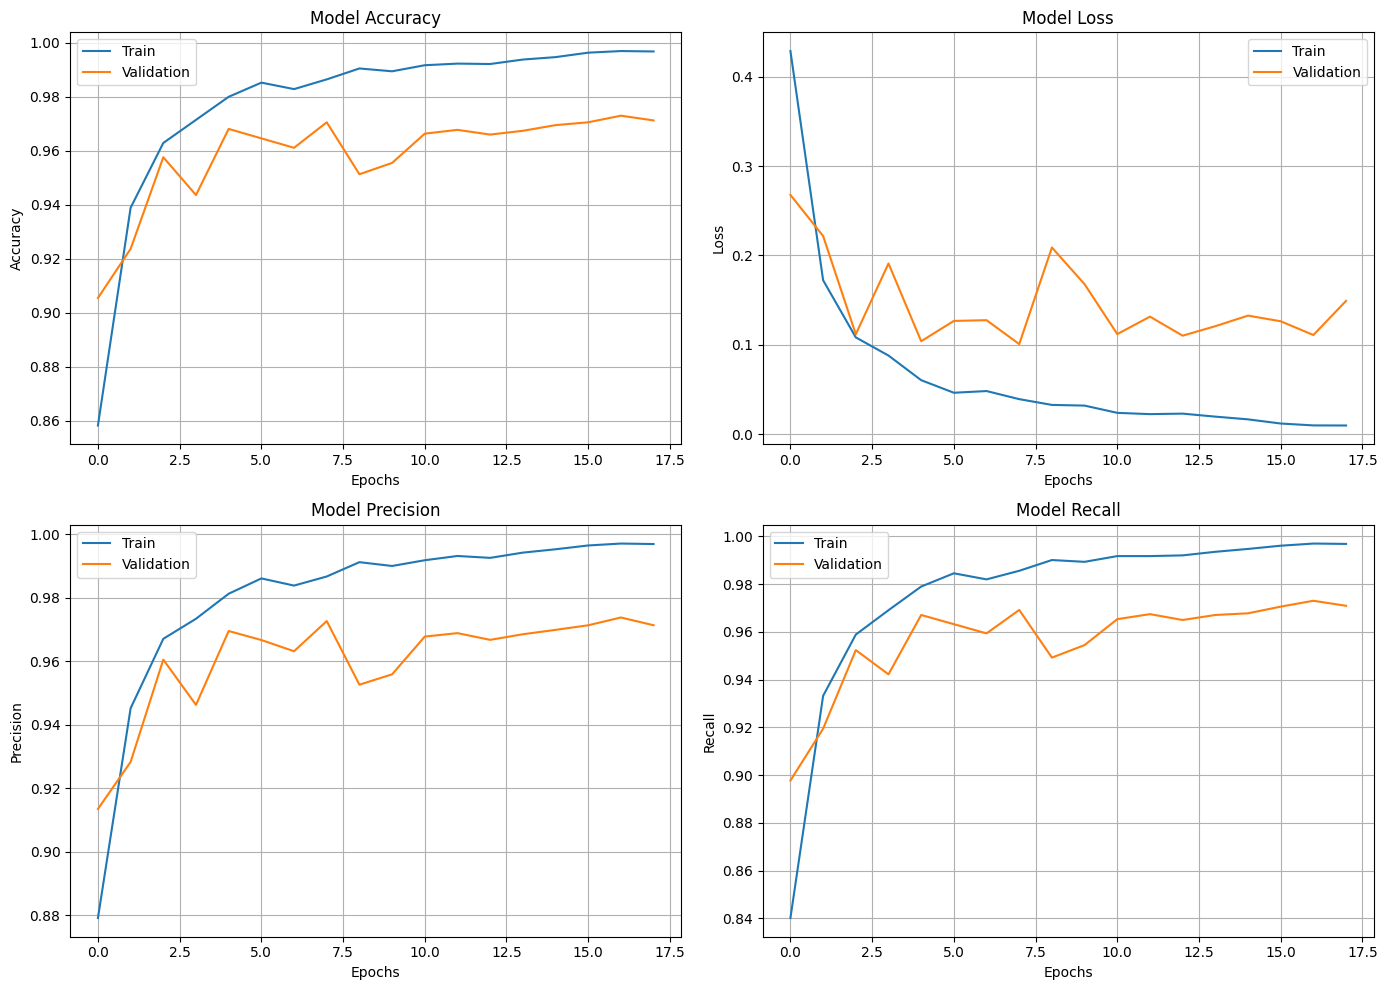

In [70]:
import matplotlib.pyplot as plt

# Set up 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].plot(hist.history['accuracy'])
axs[0, 0].plot(hist.history['val_accuracy'])
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(['Train', 'Validation'])
axs[0, 0].grid(True)

# Loss
axs[0, 1].plot(hist.history['loss'])
axs[0, 1].plot(hist.history['val_loss'])
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(['Train', 'Validation'])
axs[0, 1].grid(True)

# Precision
axs[1, 0].plot(hist.history['precision'])
axs[1, 0].plot(hist.history['val_precision'])
axs[1, 0].set_title('Model Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(['Train', 'Validation'])
axs[1, 0].grid(True)

# Recall
axs[1, 1].plot(hist.history['recall'])
axs[1, 1].plot(hist.history['val_recall'])
axs[1, 1].set_title('Model Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend(['Train', 'Validation'])
axs[1, 1].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()

**MobileNet**

In [71]:
from tensorflow.keras.applications import MobileNet

res = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
res.trainable = False

# Add custom layers on top
x = res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Optional dropout to help with generalization
# x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(5, activation='softmax')(x)  # 5-class classifier

# Build the model
model = Model(inputs=res.input, outputs=x)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# Show model summary
model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,893,445 (14.85 MB)

 Trainable params: 660,997 (2.52 MB)

 Non-trainable params: 3,232,448 (12.33 MB)

In [73]:
hist = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=50,
    batch_size=32,
    callbacks=[custom_early_stopping]
)

Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.8824 - loss: 0.3393 - precision: 0.8977 - recall: 0.8673 - val_accuracy: 0.9377 - val_loss: 0.1915 - val_precision: 0.9443 - val_recall: 0.9317
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9435 - loss: 0.1513 - precision: 0.9501 - recall: 0.9393 - val_accuracy: 0.9233 - val_loss: 0.2575 - val_precision: 0.9276 - val_recall: 0.9198
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9650 - loss: 0.1010 - precision: 0.9687 - recall: 0.9633 - val_accuracy: 0.9450 - val_loss: 0.1714 - val_precision: 0.9505 - val_recall: 0.9422
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9724 - loss: 0.0801 - precision: 0.9760 - recall: 0.9712 - val_accuracy: 0.9541 - val_loss: 0.1335 - val_precision: 0.9568 - val_recall: 0.9531
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9853 - loss: 0.0492 - precision: 0.9856 - recall: 0.9844 - val_accuracy: 0.9576 - val_lo

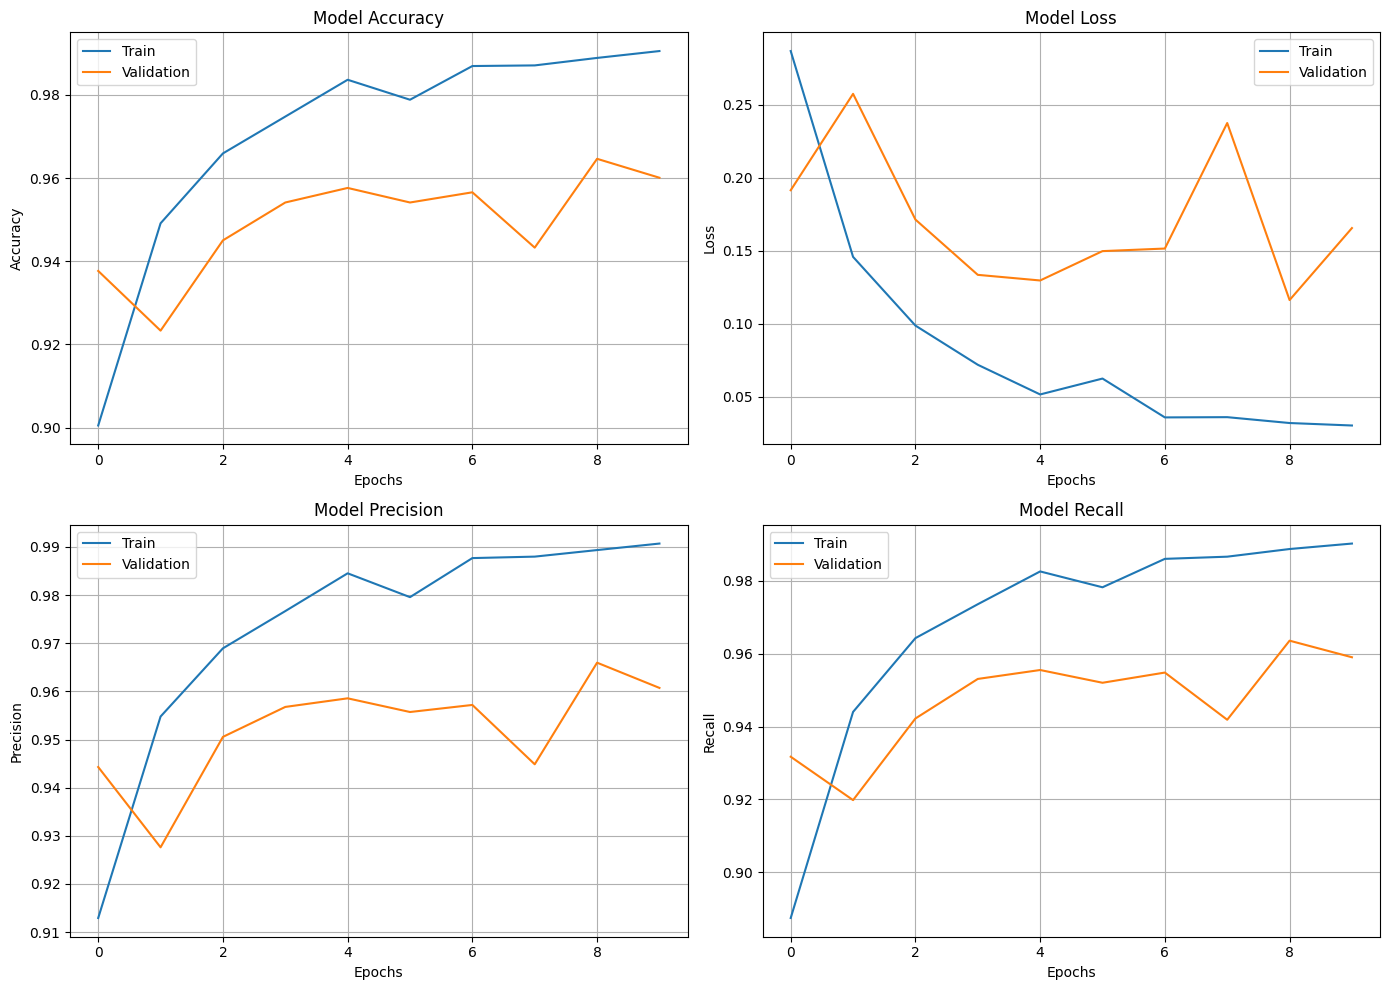

In [74]:
import matplotlib.pyplot as plt

# Set up 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].plot(hist.history['accuracy'])
axs[0, 0].plot(hist.history['val_accuracy'])
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(['Train', 'Validation'])
axs[0, 0].grid(True)

# Loss
axs[0, 1].plot(hist.history['loss'])
axs[0, 1].plot(hist.history['val_loss'])
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(['Train', 'Validation'])
axs[0, 1].grid(True)

# Precision
axs[1, 0].plot(hist.history['precision'])
axs[1, 0].plot(hist.history['val_precision'])
axs[1, 0].set_title('Model Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(['Train', 'Validation'])
axs[1, 0].grid(True)

# Recall
axs[1, 1].plot(hist.history['recall'])
axs[1, 1].plot(hist.history['val_recall'])
axs[1, 1].set_title('Model Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend(['Train', 'Validation'])
axs[1, 1].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()

**Inception**

In [76]:
from tensorflow.keras.applications import InceptionV3


res = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
res.trainable = False

# Add custom layers on top
x = res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# Optional dropout to help with generalization
# x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(5, activation='softmax')(x)  # 5-class classifier

# Build the model
model = Model(inputs=res.input, outputs=x)

# Compile the model with optimizer, loss, and metrics
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

# Show model summary
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 111, 111, 32)   │            864 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_40    │ (None, 111, 111, 32)   │             96 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_41    │ (None, 109, 109, 32)   │             96 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_42    │ (None, 109, 109, 64)   │            192 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_43    │ (None, 54, 54, 80)     │            240 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_44    │ (None, 52, 52, 192)    │            576 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 22,995,749 (87.72 MB)

 Trainable params: 1,187,333 (4.53 MB)

 Non-trainable params: 21,808,416 (83.19 MB)

In [77]:
hist = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_test, y_test_categorical),
    epochs=20,
    batch_size=32,
    callbacks=[custom_early_stopping]
)

Epoch 1/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - accuracy: 0.7456 - loss: 0.8073 - precision: 0.7782 - recall: 0.7071 - val_accuracy: 0.8743 - val_loss: 0.3454 - val_precision: 0.8898 - val_recall: 0.8592
Epoch 2/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.9277 - loss: 0.1933 - precision: 0.9402 - recall: 0.9203 - val_accuracy: 0.8981 - val_loss: 0.2978 - val_precision: 0.9094 - val_recall: 0.8897
Epoch 3/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9639 - loss: 0.1105 - precision: 0.9672 - recall: 0.9575 - val_accuracy: 0.9170 - val_loss: 0.2869 - val_precision: 0.9200 - val_recall: 0.9142
Epoch 4/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.9733 - loss: 0.0727 - precision: 0.9766 - recall: 0.9711 - val_accuracy: 0.9188 - val_loss: 0.2854 - val_precision: 0.9234 - val_recall: 0.9156
Epoch 5/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.9789 - loss: 0.0637 - precision: 0.9811 - recall: 0.9771 - val_accuracy: 0.9373 - v

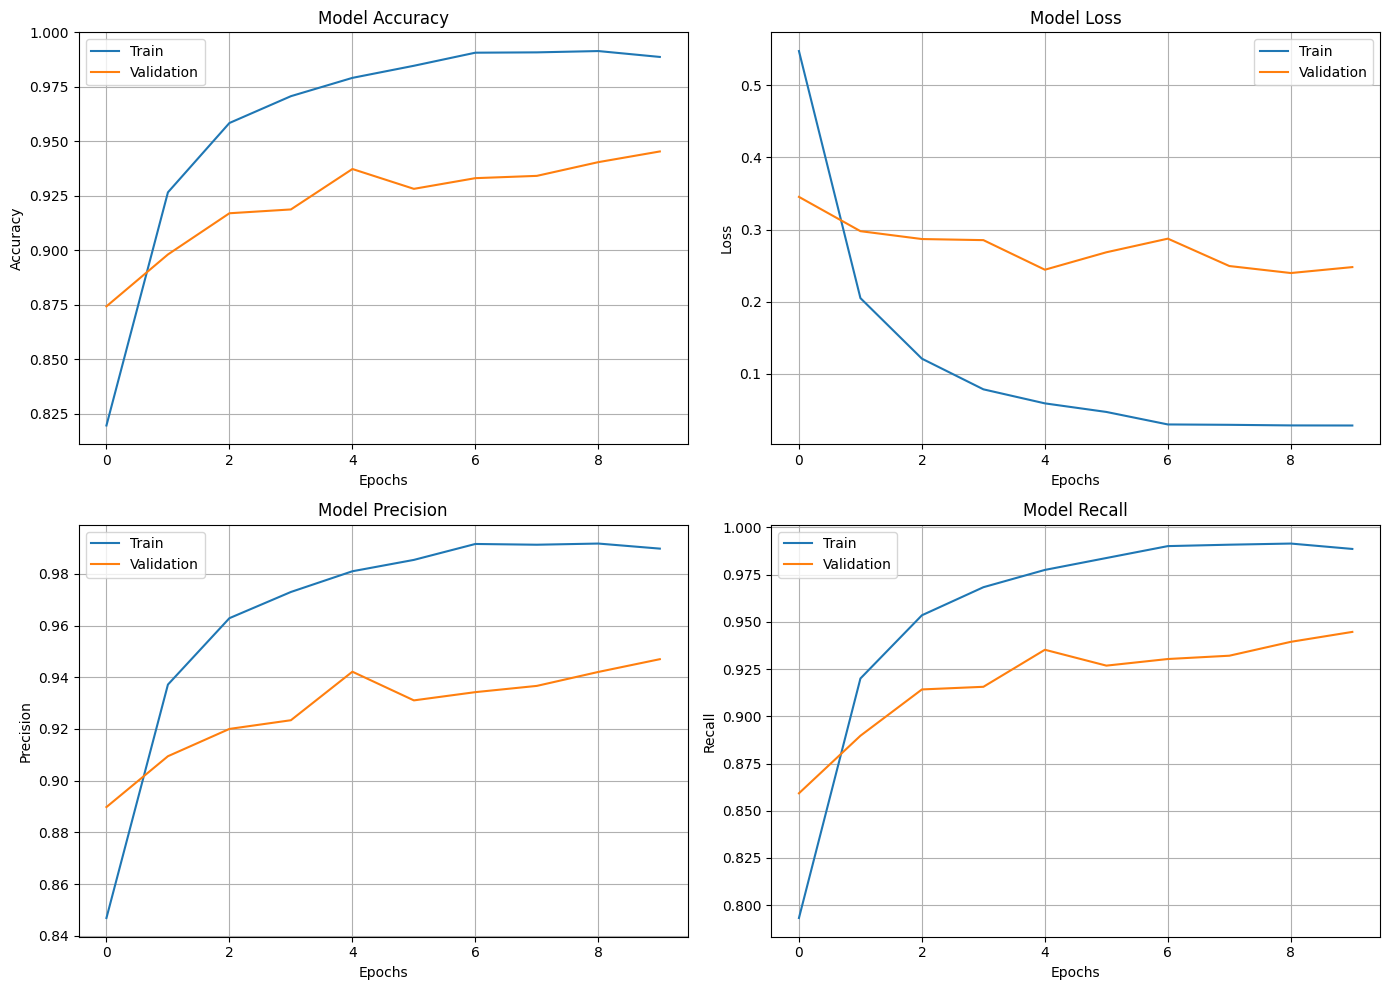

In [78]:
import matplotlib.pyplot as plt

# Set up 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axs[0, 0].plot(hist.history['accuracy'])
axs[0, 0].plot(hist.history['val_accuracy'])
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(['Train', 'Validation'])
axs[0, 0].grid(True)

# Loss
axs[0, 1].plot(hist.history['loss'])
axs[0, 1].plot(hist.history['val_loss'])
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(['Train', 'Validation'])
axs[0, 1].grid(True)

# Precision
axs[1, 0].plot(hist.history['precision'])
axs[1, 0].plot(hist.history['val_precision'])
axs[1, 0].set_title('Model Precision')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(['Train', 'Validation'])
axs[1, 0].grid(True)

# Recall
axs[1, 1].plot(hist.history['recall'])
axs[1, 1].plot(hist.history['val_recall'])
axs[1, 1].set_title('Model Recall')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend(['Train', 'Validation'])
axs[1, 1].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()